# Preprocessing Sentinel-2 images

The different preprocessing step are as following :

1. Resample 20m spatial resolutions bands to 10m (if you want to work with Red, Green, Blue, NIR bands)
2. Cropping images to the extent of Region of Interest (ROI)
3. Apply Scene Classification map (SCL) on reflectance images to mask invalid pixels

<figure class="image">
  <img src="prepro_S2.png" alt="S2 preprocessing" width="1100">
</figure>

If your ROI spans several S2 tiles, start by preprocessing each tile one by one using this notebook and then use the "Mosaic Sentinel-2 tiles" notebook to mosaic the entire ROI.

In [52]:
import glob, os
import numpy as np
import geopandas as gpd
import rasterio
import rasterio.mask
import rasterio.plot
from rasterio.enums import Resampling
import matplotlib.pyplot as plt
from pathlib import Path

print('All libraries successfully imported!')
print(f'Rasterio : {rasterio.__version__}')

All libraries successfully imported!
Rasterio : 1.3.4


**Set directory**

In [53]:
computer_path = '/export/miro/ndeffense/LBRAT2104/'
grp_nb        = '99'

work_path = f'{computer_path}STUDENTS/GROUP_{grp_nb}/TP/'  # Directory for all your work files
data_path = f'{computer_path}data/'                        # Directory for data shared by the assistant

roi_path = f'{work_path}ROI/'
dwl_path = f'{data_path}DOWNLOAD/'


# For each step of the preprocessing,
# a folder will be created to store 
# the intermediary files.

resampled_path = f'{work_path}1_L2A_RESAMPLED/'
clipped_path   = f'{work_path}2_L2A_CLIPPED_4tiles/'
masked_path    = f'{work_path}3_L2A_MASKED_4tiles/'

Path(resampled_path).mkdir(parents=True, exist_ok=True)
Path(clipped_path).mkdir(parents=True, exist_ok=True)
Path(masked_path).mkdir(parents=True, exist_ok=True)

**Set region of interest**

In [54]:
crs = 'EPSG:32631'

roi_name     = 'extent_roi_4tiles'
roi_filename = f'{roi_name}_{crs[5:]}.shp'
roi_file     = f'{roi_path}{roi_filename}'

roi_gdf = gpd.read_file(roi_file)

print(f'ROI shapefile : {roi_file}')

ROI shapefile : /export/miro/ndeffense/LBRAT2104/STUDENTS/GROUP_99/TP/ROI/extent_roi_4tiles_32631.shp


Select reflectance bands you want to work with

* 10 metre spatial resolution
    - B2 - Blue
    - B3 - Green
    - B4 - Red
    - B8 - Near Infra-Red (NIR)

* 20 metre spatial resolution
    - B5 - Red-Edge
    * B6 - Red-Edge
    * B7 - Red-Edge
    * B8a - Near Infra-Red (NIR)
    * B11 - Short Wave Infra-Red (SWIR)
    * B12 - Short Wave Infra-Red (SWIR)

In [56]:
band_10m_list = ['B04','B08']

band_20m_list = ['B11']

**Set parameters**

In [57]:
# We will upscale the image by 2: 20m --> 10m
upscale_factor = 2

# As SCL is categorical data, we MUST use "nearest neighbor" resampling method
resampling_method_categorical = Resampling.nearest

# As BOA is continuous data, we can use other resampling methods : nearest, bilinear, cubic
resampling_method_continuous = Resampling.bilinear

nodata_val = -10000

Get the list of Sentinel-2 data that will be preprocessed

In [58]:
list_L2A = glob.glob(f'{dwl_path}S2*.SAFE')

print(f'{len(list_L2A)} L2A will be pre-processed \n')

for L2A_safe in list_L2A:
    L2A_name = os.path.basename(L2A_safe)
    print(L2A_name)

16 L2A will be pre-processed 

S2A_MSIL2A_20200417T104021_N0214_R008_T31UFS_20200417T112906.SAFE
S2A_MSIL2A_20200520T105031_N0214_R051_T31UFS_20200520T134332.SAFE
S2A_MSIL2A_20200719T105031_N0214_R051_T31UFS_20200719T134605.SAFE
S2A_MSIL2A_20200914T104031_N0214_R008_T31UFS_20200914T133417.SAFE
S2B_MSIL2A_20200116T105309_N0213_R051_T31UFS_20200116T122813.SAFE
S2B_MSIL2A_20200212T104049_N0214_R008_T31UFS_20200213T134833.SAFE
S2B_MSIL2A_20200316T104709_N0214_R051_T31UFS_20200316T135256.SAFE
S2B_MSIL2A_20200621T103629_N0214_R008_T31UFS_20200621T140338.SAFE
S2B_MSIL2A_20200813T104629_N0214_R051_T31UFS_20200813T133458.SAFE
S2B_MSIL2A_20201019T103959_N0214_R008_T31UFS_20201019T140516.SAFE
S2B_MSIL2A_20201118T104329_N0214_R008_T31UFS_20201118T123717.SAFE
S2B_MSIL2A_20201218T104349_N0214_R008_T31UFS_20201218T124059.SAFE
S2A_MSIL2A_20200805T104031_N0214_R008_T31UFS_20200805T121101.SAFE
S2A_MSIL2A_20200805T104031_N0214_R008_T31UFR_20200805T121101.SAFE
S2A_MSIL2A_20200805T104031_N0214_R008_T31UGS_

## 1. Resample images at 20m resolution to 10m

| Methods | Type of data | How it works |
|:---------:|:----------:| ---- |
| Nearest Neighbor | categorical| <font size="2">The value of of the output cell is determined by the nearest cell center on the input grid </font>|
| Bilinear Interpolation | continuous | <font size="2"> Weighted average of the four nearest cell centers. <br/> The closer an input cell center is to the output cell center, the higher the influence of its value is on the output cell value. The output value could be different than the nearest input but is always within the same range of values as the input. </font>|
| Cubic Convolution | continuous | <font size="2">Looks at the 16 nearest cell centers to the output and fits a smooth curve through the points to find the value. <br/>Not only does this change the values of the input but it could also cause the output value to be outside of the range of input values (imagine a sink or a peak occurring on a surface). </font> |


### 1.1 Resample Scene Classification map

> **WARNING**: Only if you are planning to work at 10m resolution. If you are planning to work at 20m resolution, you can skip this step!

In [60]:
for L2A_safe in list_L2A:

    im_file_20m = glob.glob(f'{L2A_safe}/GRANULE/*/IMG_DATA/R20m/*_SCL_20m.jp2')[0]
    im_file_20m = im_file_20m.replace('\\','/')

    im_file_10m = f'{resampled_path}{os.path.basename(im_file_20m).replace("20m","10m").replace("jp2","tif")}'
    
    if not os.path.isfile(im_file_10m):

        # Open file
        src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

        # Resample data to target shape
        resampled_data = src.read(out_shape = (src.count,
                                               int(src.height * upscale_factor),
                                               int(src.width * upscale_factor)
                                               ),
                                  resampling = resampling_method_categorical)

        # Scale image transform
        new_transform = src.transform * src.transform.scale(
            (src.width / resampled_data.shape[-1]),
            (src.height / resampled_data.shape[-2])
        )

        # Update metadata
        profile = src.profile
        profile.update(driver = 'GTiff',
                       width = src.width*upscale_factor,
                       height = src.height*upscale_factor,
                       transform = new_transform)


        # Write resampled image
        dst = rasterio.open(im_file_10m, "w", **profile)
        dst.write(resampled_data)

        # Close rasterio objects
        src.close()
        dst.close()
        
        print(f'--> A new resampled raster file is created : {im_file_10m}')

print('--> All SCL are resampled !')


--> All SCL are resampled !


### 1.2 Resample Bottom-Of-Atmosphere corrected reflectance

If you work only with Blue (B02), Green (B03), Red (B04) and NIR (B08) bands, you don't have to do the resampling step because theses reflectances are already available at 10m resolution.

This step is only necessary if you work with bands 5,6,7,8A,11,12 which are only available at 20m resolution.

In [62]:
for L2A_safe in list_L2A:

    for band in band_20m_list:
        
        im_file_20m = glob.glob(f'{L2A_safe}/GRANULE/*/IMG_DATA/R20m/*{band}_20m.jp2')[0]
        im_file_20m = im_file_20m.replace('\\','/')

        im_file_10m = f'{resampled_path}{os.path.basename(im_file_20m).replace("20m","10m").replace("jp2","tif")}'


        if not os.path.isfile(im_file_10m):

            # Open file
            src = rasterio.open(im_file_20m, "r", driver='JP2OpenJPEG')

            # Resample data to target shape
            resampled_data = src.read(out_shape = (src.count,
                                                   int(src.height * upscale_factor),
                                                   int(src.width * upscale_factor)
                                                   ),
                                    resampling = resampling_method_continuous)

            # Scale image transform
            new_transform = src.transform * src.transform.scale(
                (src.width / resampled_data.shape[-1]),
                (src.height / resampled_data.shape[-2])
            )

            # Update metadata
            profile = src.profile
            profile.update(driver = 'GTiff',
                           width = src.width*upscale_factor,
                           height = src.height*upscale_factor,
                           transform = new_transform)


            # Write resampled image
            dst = rasterio.open(im_file_10m, "w", **profile)
            dst.write(resampled_data)

            # Close rasterio objects
            src.close()
            dst.close()
            
            print(f'--> A new resampled raster file is created : {im_file_10m}')

print('--> All reflectances are resampled !')


--> All reflectances are resampled !


## 2. Clip images to the extent of Region of Interest

We can use our ROI (vector) to clip satellite images (raster) into a smaller area to reduce image storage and speed up further processing.

Get list of all images to clip

> **WARNING**: All images must be at same spatial resolution !

In [63]:
list_im_to_clip = glob.glob(f'{resampled_path}*_10m.tif')

for band in band_10m_list:

    list_im_to_clip += glob.glob(f'{dwl_path}*.SAFE/GRANULE/*/IMG_DATA/R10m/*{band}_10m.jp2')

print(f'There are {len(list_im_to_clip)} images to clip')

There are 76 images to clip


**Check if the ROI is located in one of the image to clip**

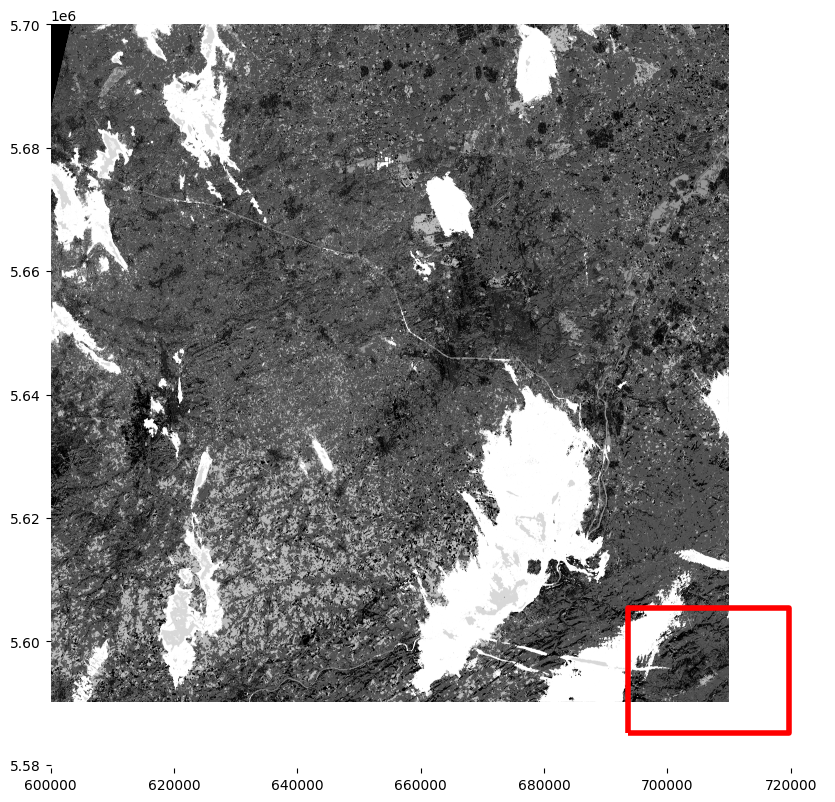

In [64]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot image

# First image of the list
im_file = list_im_to_clip[0]

# A cloudy image
#im_file = [s for s in list_im_to_clip if all(xs in s for xs in ['20200621','B04'])][0]

src = rasterio.open(im_file, "r")
im = src.read(1)

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 5)
p95 = np.nanpercentile(im, 95)
rasterio.plot.show(src, cmap='Greys_r', vmin=p5, vmax=p95, ax=ax)

# Plot vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 4, ax=ax)

plt.box(False)

**Clip images**

In [66]:
for im_file in list_im_to_clip:

    im_file_roi = f'{clipped_path}{os.path.basename(im_file)[:-4]}_ROI.tif'
    
    if not os.path.isfile(im_file_roi):
        
        # Open file
        src = rasterio.open(im_file, "r")

        # Clip the raster to the extent of the shape
        out_image, out_transform = rasterio.mask.mask(src,
                                                      roi_gdf.geometry,
                                                      all_touched=True,
                                                      crop=True)

        # Update metadata
        out_meta = src.meta

        out_meta.update(driver='GTiff',
                        width = out_image.shape[2],
                        height = out_image.shape[1],
                        transform = out_transform)

        # Write clipped image
        dst = rasterio.open(im_file_roi, "w", **out_meta)
        dst.write(out_image)

        # Close rasterio objects
        src.close()
        dst.close()


        print(f'A new raster file is created : {im_file_roi}')

print('--> All images are clipped !')


--> All images are clipped !


**Check if clipped image is located inside the ROI**

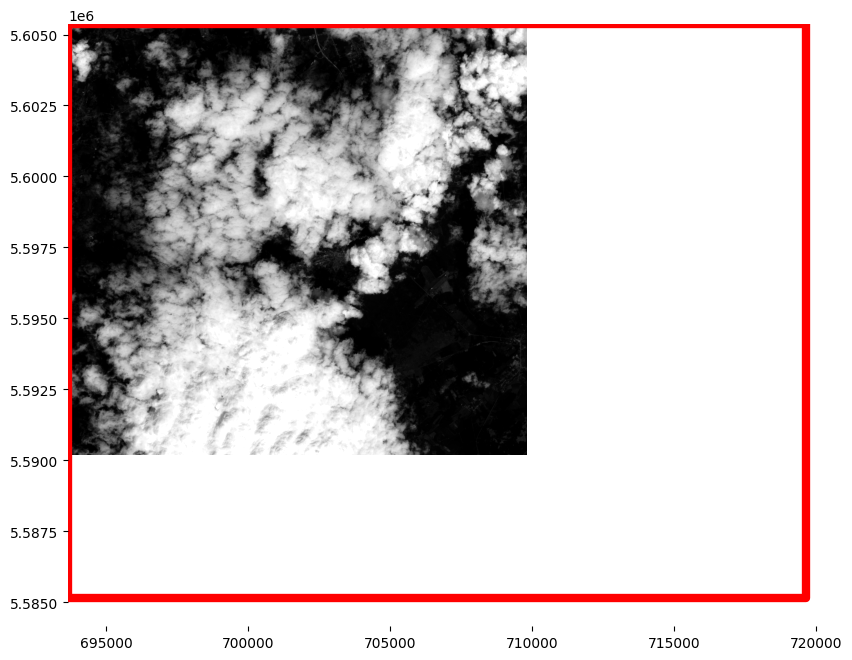

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(10,10))

# Plot image

# First image of the list
#im_file = glob.glob(f'{clipped_path}*_B*.tif')[0]

# A cloudy image
im_file = glob.glob(f'{clipped_path}*20200621*B04*.tif')[0]


src = rasterio.open(im_file, "r")
im = src.read(1)

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 5)
p95 = np.nanpercentile(im, 95)

rasterio.plot.show(src, cmap='Greys_r', vmin=p5, vmax=p95, ax=ax)

# Plot vector
roi_gdf.plot(facecolor='none', edgecolor='red', linewidth = 6, ax=ax)

plt.box(False)

## 3. Atmospheric correction & Cloud screening

### 3.1 Atmospheric correction

Atmospheric correction allows calculation of Bottom Of Atmosphere (BOA) reflectance from Top Of Atmosphere (TOA) reflectance images available in L1C products. For Sentinel-2 images, we will directly use the L2A data as available from the ground segment.

### 3.2 Cloud screening

Reliable identification of clouds and cloud shadows are necessary for any optical remote sensing image analysis, especially in operational and fully automatic setups. The cloud screening can be achieved using different algorithms (Sen2Cor, MAJA, Fmask). In this course we will work with Sen2Cor as the mask is already present in L2A products.

Scene Classification map (SCL) aims at providing a pixel classification map (cloud, cloud shadows, vegetation, soils/deserts, water, snow, etc.)

The SC algorithm enables:
- generation of a classification map which includes four different classes for clouds (including cirrus) and six different classifications for shadows, cloud shadows, vegetation, soils/deserts, water and snow
- provision of associated quality indicators corresponding to a map of cloud probability and a map of snow probability.

SCL class| Description
:---------:|:----------:
0| No data
1| Saturated or defective
2|	Dark area pixels
3|	Cloud shadows
4|	Vegetation
5|	Not vegetated
6|	Water
7|	Unclassified
8|	Cloud medium probability
9|	Cloud high probability
10|	Thin cirrus
11|	Snow

Get a list with all reflectance bands clipped on the ROI

In [68]:
list_im_ROI = glob.glob(f'{clipped_path}*_B*_ROI.tif')

print(f'There are {len(list_im_ROI)} images where we have to apply SCL map')

There are 60 images where we have to apply SCL map


Apply SCL

In [70]:
for im_file in list_im_ROI:
    
    # Get date of image
    date = os.path.basename(im_file)[7:7+15]

    # Get tile of image
    tile = os.path.basename(im_file)[0:6]
        
    # Find SCL corresponding to the given reflectances image (same date and same tile)
    scl_file = glob.glob(f'{clipped_path}*{tile}*{date}*SCL_10m_ROI.tif')[0]
    scl_file = scl_file.replace('\\','/')
    
    im_file_scl = f'{masked_path}{os.path.basename(im_file)[:-4]}_SCL.tif'
    
    if not os.path.isfile(im_file_scl):
        
        # Open SCL and change invalid pixels categories by NaN
        src = rasterio.open(scl_file, "r")

        # Read file as numpy array
        SCL = src.read(1)
        src.close()

        #print('Scene Classification map')
        #show(SCL, cmap='Set3')

        SCL = SCL.astype(float)

        SCL[SCL == 0] = np.nan    # No data
        SCL[SCL == 1] = np.nan    # Saturated or defective
        SCL[SCL == 2] = np.nan    # Dark area pixels
        SCL[SCL == 3] = np.nan    # Cloud shadows
        SCL[SCL == 4] = 1         # Vegetation
        SCL[SCL == 5] = 1         # Not vegetated
        SCL[SCL == 6] = 1         # Water
        SCL[SCL == 7] = 1         # Unclassified
        SCL[SCL == 8] = np.nan    # Cloud medium probability
        SCL[SCL == 9] = np.nan    # Cloud high probability
        SCL[SCL == 10] = np.nan   # Thin cirrus
        SCL[SCL == 11] = np.nan   # Snow

        # Open file
        src = rasterio.open(im_file, "r")

        # Read file as numpy array
        im = src.read(1)

        # Update metadata
        profile = src.profile
        profile.update(dtype=rasterio.int16,  # Set to int16 it is lighter than float
                       nodata=nodata_val,     # Set nodata value in metadata
                       compress='lzw')        # Compression option

        # Mask image reflectance with SCL
        im_SLC = im * SCL

        # Change numpy NaN by nodata_val (e.g. -10000)
        im_SLC[np.isnan(im_SLC)] = nodata_val

        # Change the array's type : from float to integer 16
        im_SLC = im_SLC.astype(np.int16)

        # Write image
        dst = rasterio.open(im_file_scl, 'w', **profile)
        dst.write(im_SLC, 1)

        # Close rasterio objects
        src.close()
        dst.close()

        print(f'A new raster file is created : {im_file_scl}')

print('--> SCL is applied on all images !')


--> SCL is applied on all images !


**Check if the SCL was correctly applied**

<AxesSubplot: title={'center': 'After SCL'}>

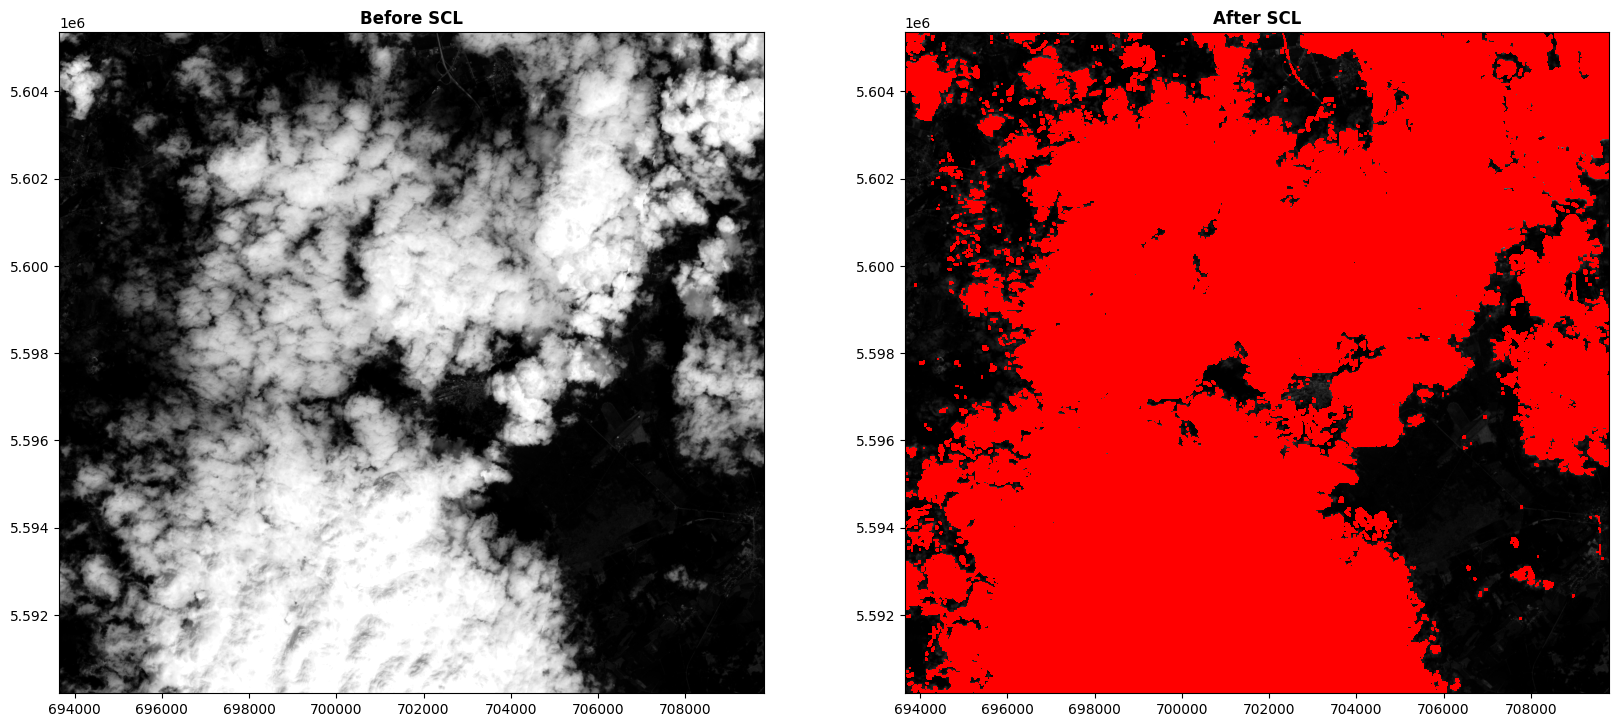

In [71]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

date_to_display = '20200621'

# Plot reflectance image before applying SCL
# ------------------------------------------

im_file_reflect = glob.glob(f'{clipped_path}*{date_to_display}*B04*.tif')[0]
#im_file_reflect = glob.glob(f'{clipped_path}*31UFR*B04*.tif')[0]


src = rasterio.open(im_file_reflect, "r")
im = src.read(1)

im = im.astype(float)
im = np.where(im == nodata_val, np.nan, im)
p5 = np.nanpercentile(im, 5)
p95 = np.nanpercentile(im, 95)

rasterio.plot.show(src, ax=ax1, cmap='Greys_r', vmin=p5, vmax=p95, title="Before SCL")


# Plot reflectance image after applying SCL
# -----------------------------------------

im_file_scl = glob.glob(f'{masked_path}*{date_to_display}*B04*.tif')[0]
#im_file_scl = glob.glob(f'{masked_path}*31UFR*B04*.tif')[0]


src = rasterio.open(im_file_scl, "r")

color_map = plt.cm.get_cmap("Greys_r")
color_map.set_bad(color='red')

rasterio.plot.show(src, ax=ax2, cmap=color_map, vmin=p5, vmax=p95, title="After SCL")